In [86]:
pip install wordcloud


   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/301.2 kB 1.3 MB/s eta 0:00:01
   ---- ----------------------------------- 30.7/301.2 kB 1.3 MB/s eta 0:00:01
   ----- --------------------------------- 41.0/301.2 kB 281.8 kB/s eta 0:00:01
   ----------- --------------------------- 92.2/301.2 kB 525.1 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/301.2 kB 595.3 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/301.2 kB 450.6 kB/s eta 0:00:01
   ------------------------ ------------- 194.6/301.2 kB 620.6 kB/s eta 0:00:01
   ------------------------------------ - 286.7/301.2 kB 803.7 kB/s eta 0:00:01
   -------------------------------------- 301.2/301.2 kB 744.1 kB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [3]:
# Loading JSON file
df = pd.read_json("C:/Users/user/Documents/PAU/Semester2/DAT602/Beauty_5.json", lines=True)

In [5]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      198502 non-null  object
 1   asin            198502 non-null  object
 2   reviewerName    197116 non-null  object
 3   helpful         198502 non-null  object
 4   reviewText      198502 non-null  object
 5   overall         198502 non-null  int64 
 6   summary         198502 non-null  object
 7   unixReviewTime  198502 non-null  int64 
 8   reviewTime      198502 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.6+ MB
None


In [7]:
print (df.head())

       reviewerID        asin reviewerName helpful  \
0  A1YJEY40YUW4SE  7806397051       Andrea  [3, 4]   
1   A60XNB876KYML  7806397051   Jessica H.  [1, 1]   
2  A3G6XNM240RMWA  7806397051        Karen  [0, 1]   
3  A1PQFP6SAJ6D80  7806397051        Norah  [2, 2]   
4  A38FVHZTNQ271F  7806397051    Nova Amor  [0, 0]   

                                          reviewText  overall  \
0  Very oily and creamy. Not at all what I expect...        1   
1  This palette was a decent price and I was look...        3   
2  The texture of this concealer pallet is fantas...        4   
3  I really can't tell what exactly this thing is...        2   
4  It was a little smaller than I expected, but t...        3   

                  summary  unixReviewTime   reviewTime  
0  Don't waste your money      1391040000  01 30, 2014  
1             OK Palette!      1397779200  04 18, 2014  
2           great quality      1378425600   09 6, 2013  
3  Do not work on my face      1386460800   12 8, 2013  

In [9]:
print (df.columns)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')


In [11]:
#Checking for missing values
print (df.isnull().sum())

reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64


In [13]:
df["reviewerName"] = df["reviewerName"].fillna("Anonymous")

In [15]:
print (df.isnull().sum())

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64


In [17]:
def assign_sentiment(rating):
    if rating <= 2:
        return "Negative"
    if rating == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["overall"].apply(assign_sentiment)

In [19]:
print(df[["overall","sentiment"]].head())

   overall sentiment
0        1  Negative
1        3   Neutral
2        4  Positive
3        2  Negative
4        3   Neutral


In [21]:
#Checking sentiment distribution
sentiment_counts = df["sentiment"].value_counts()
print (sentiment_counts)

sentiment
Positive    154272
Neutral      22248
Negative     21982
Name: count, dtype: int64


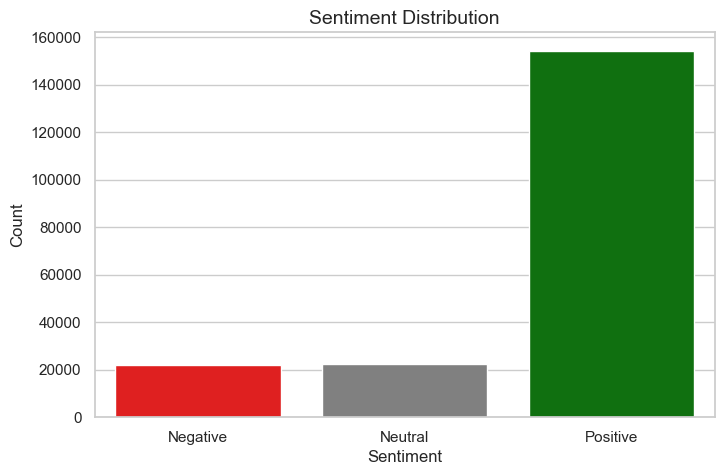

In [23]:
#Visualizing the sentiment distribution
#plot barchart
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.countplot(x=df["sentiment"], data=df, hue="sentiment", palette=["red","gray","green"], legend=False)

plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

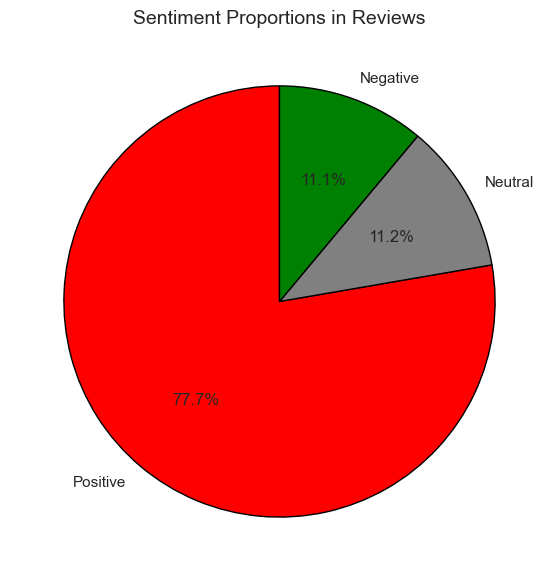

In [25]:
#plot piechart
plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=["red", "gray", "green"], startangle=90, wedgeprops={"edgecolor":"black"})

plt.title("Sentiment Proportions in Reviews", fontsize=14)
plt.show()

In [27]:
#Cleaning the reviewText column
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_review"] = df["reviewText"].astype(str).apply(clean_text)

In [29]:
print (df[["reviewText","cleaned_review"]].head())

                                          reviewText  \
0  Very oily and creamy. Not at all what I expect...   
1  This palette was a decent price and I was look...   
2  The texture of this concealer pallet is fantas...   
3  I really can't tell what exactly this thing is...   
4  It was a little smaller than I expected, but t...   

                                      cleaned_review  
0  very oily and creamy not at all what i expecte...  
1  this palette was a decent price and i was look...  
2  the texture of this concealer pallet is fantas...  
3  i really cant tell what exactly this thing is ...  
4  it was a little smaller than i expected but th...  


In [31]:
# Separating positive and negative reviews
positive_reviews = " ".join(df[df["sentiment"] == "Positive"]["cleaned_review"])
negative_reviews = " ".join(df[df["sentiment"] == "Negative"]["cleaned_review"])

# Generating word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_reviews)

Text(0.5, 1.0, 'Most Common Words in Positive Reviews')

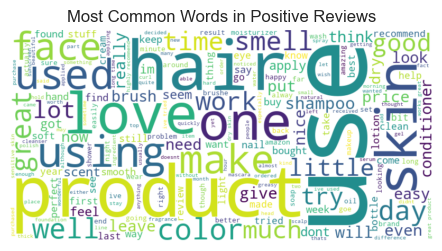

In [33]:
#plotting positive wordcloud
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Positive Reviews") 

Text(0.5, 1.0, 'Most Common Words in Negative Reviews')

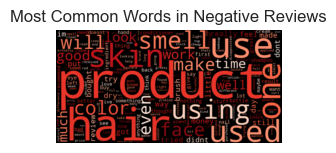

In [35]:
#plotting negative wordcloud
plt.subplot(1,2,2)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Negative Reviews")

In [37]:
# Storing the original text reviews
X_raw = df["cleaned_review"]  # Save original text before TF-IDF transformation

# Converting text into TF-IDF vectors
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(X_raw)

# Convert sentiment labels into numbers
sentiment_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
y = df["sentiment"].map(sentiment_mapping)

In [39]:
#Splitting dataset into train, validate and test
X_train,X_val_test,y_train,y_val_test,X_train_raw, X_val_test_raw=train_test_split(X,y,X_raw,test_size=0.4,random_state=42)
X_val,X_test,y_val,y_test,X_val_raw, X_test_raw=train_test_split(X_val_test,y_val_test,X_val_test_raw,test_size=0.5,random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 119101 samples
Validation set: 39700 samples
Test set: 39701 samples


In [41]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (119101, 5000), y_train shape: (119101,)
X_val shape: (39700, 5000), y_val shape: (39700,)


In [43]:
#Defining the Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric="mlogloss")
}

results={}

In [45]:
for name, model in models.items():
    print(f"\n {name}")
    try:
        model.fit(X_train, y_train)  # Train the model
        y_val_pred = model.predict(X_val)  # Make predictions
        report = classification_report(y_val, y_val_pred, output_dict=True)  # Get report as a dict
        results[name] = report  # Store report
        
        print(f"\n{name} Classification Report:")
        print(classification_report(y_val, y_val_pred))  # Print the report
        
    except Exception as e:
        print(f"⚠️ {name} failed to train: {e}")  # Print the specific error


 Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.55      0.62      4369
           1       0.50      0.25      0.33      4487
           2       0.88      0.97      0.92     30844

    accuracy                           0.84     39700
   macro avg       0.69      0.59      0.62     39700
weighted avg       0.81      0.84      0.82     39700


 Naïve Bayes

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.07      0.14      4369
           1       0.67      0.00      0.00      4487
           2       0.78      1.00      0.88     30844

    accuracy                           0.78     39700
   macro avg       0.78      0.36      0.34     39700
weighted avg       0.78      0.78      0.70     39700


 Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0 

In [47]:
#Selecting the best model
best_model = max(results, key=lambda k: results[k]['weighted avg']['f1-score'])
print(f"Best Model: {best_model}")
print(f"Weighted F1-score: {results[best_model]['weighted avg']['f1-score']:.4f}")

Best Model: Logistic Regression
Weighted F1-score: 0.8202


In [55]:
#Evaluating the best model on the unseen test dataset
y_test_pred = models["Logistic Regression"].predict(X_test)

print("Test Set Evaluation - Logistic Regression:")
print(classification_report(y_test, y_test_pred, target_names=["Negative", "Neutral", "Positive"]))

Test Set Evaluation - Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.71      0.55      0.62      4411
     Neutral       0.51      0.25      0.34      4430
    Positive       0.87      0.97      0.92     30860

    accuracy                           0.84     39701
   macro avg       0.70      0.59      0.62     39701
weighted avg       0.82      0.84      0.82     39701



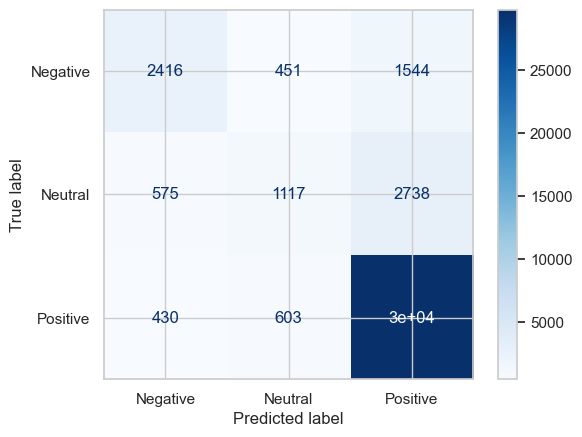

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues")

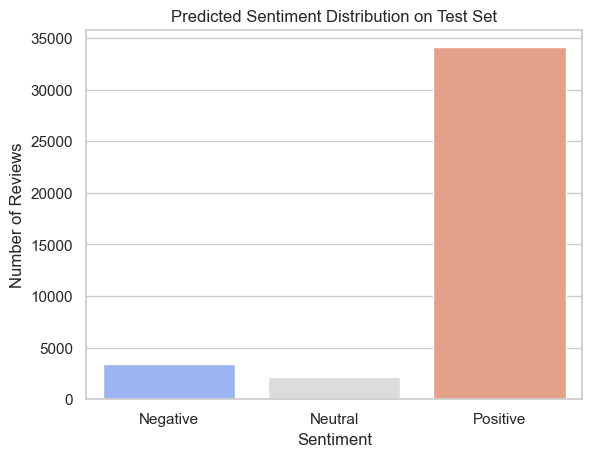

In [93]:
# Visualizing prediction distribution
pred_df = pd.DataFrame({"Predicted": y_test_pred})
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
pred_df["Sentiment"] = pred_df["Predicted"].map(label_map)

sns.countplot(x=y_test_pred, data=pred_df, hue="Sentiment", palette="coolwarm", legend=False)
plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"])
plt.title("Predicted Sentiment Distribution on Test Set")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [65]:
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [61]:
joblib.dump(models["Logistic Regression"], "logistic_sentiment_model.pkl")

['logistic_sentiment_model.pkl']

In [101]:
# Load saved model and vectorizer
loaded_model = joblib.load("logistic_sentiment_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Example prediction
sample_review = ["This shampoo smells nice but makes my hair horrible!"]
sample_tfidf = loaded_vectorizer.transform(sample_review)
predicted_sentiment = loaded_model.predict(sample_tfidf)
print(predicted_sentiment)  

[0]


In [114]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
vocab_size = 20000  
oov_token = '<OOV>'
max_len = 100  # max sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['cleaned_review'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Pad sequences
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Convert target to categorical
y_seq = to_categorical(df['sentiment'].map({"Negative":0, "Neutral":1, "Positive":2}))

# Train/val/test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes:
X_train: (119101, 100) y_train: (119101, 3)
X_val: (39700, 100) y_val: (39700, 3)
X_test: (39701, 100) y_test: (39701, 3)


In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 327s 339ms/step - accuracy: 0.7715 - loss: 0.7101 - val_accuracy: 0.7769 - val_loss: 0.6804
Epoch 2/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 294s 316ms/step - accuracy: 0.7810 - loss: 0.6451 - val_accuracy: 0.8123 - val_loss: 0.4874
Epoch 3/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 309s 331ms/step - accuracy: 0.8140 - loss: 0.4556 - val_accuracy: 0.8286 - val_loss: 0.4349
Epoch 4/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 328s 352ms/step - accuracy: 0.8392 - loss: 0.4005 - val_accuracy: 0.8327 - val_loss: 0.4300
Epoch 5/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 390s 419ms/step - accuracy: 0.8544 - loss: 0.3576 - val_accuracy: 0.8312 - val_loss: 0.4521
Epoch 6/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 326s 350ms/step - accuracy: 0.8721 - loss: 0.3204 - val_accuracy: 0.8372 - val_loss: 0.4497
Epoch 7/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 401s 431ms/step - accuracy: 0.8912 - loss: 0.2798 - val_accuracy: 0.8336 - val_loss: 0.4849
